# Estimagic with SciPy's `least_squares`

This is the accompanying documentation to the Pull Request adding the scipy [least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) to [estimagic](https://github.com/OpenSourceEconomics/estimagic).



## Table of Contents:
   1. Project Goals
   2. Modification Process
   3. Underlying Algorithms
   4. Examples
   5. Comparison

## 1. Project Goals
This project adds new internal optimizers to the estimagic library for nonlinear optimization.

### 1.1 Estimagic
[estimagic](https://github.com/OpenSourceEconomics/estimagic) is a Python package that provides tools for nonlinear optimization, numerical differentiation and statistical inference to fit large scale empirical models to data and make inferences about the estimated model parameters. It is well suited to solving difficult constrained optimization problems.

The full documentation can be accessed [here](https://estimagic.readthedocs.io/en/latest/#).

### 1.2 Contribution
estimagic provides a large collection of [internal optimizers](https://estimagic.readthedocs.io/en/latest/explanations/optimization/internal_optimizers.html). 
This project adds two least square algorithms as internal optimizers.
These two new optimizers are based on scipy's least squares implementation, see [scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#r20fc1df64af7-stir).

A third possible scipy least squares optimizer, based on the Levenberg-Marquardt algorithm, was not included. It's inabillity to handle bounds or constraints as well as the fact that it requires the number of residuals and number of variables to be equal does not make it a good fit for estimagic's internal optimizer structure.

The added optimizers:
* scipy_ls_trf
* scipy_ls_dogbox

will be explained and tested within this notebook.

## 2. Modification Process
Almost all modifications where done in the file `estimagic/optimization/scipy_optimizers.py`.
Adding the optimizers was done in the following steps:

1. Add a function `scipy_least_squares`, with the different algorithms (trf and dogbox) as parameters. Later this API was changed (see below).
2. Add the function to the test suite, by marking it as imprecise (i.e. adding it to `IMPRECISE_ALGOS` and `is_least_sqaures` lists).
3. Add relevant parameters to the function and supply them to the underlying `scipy_least_squares` function.
4. Wonder for multiple hours, why `tox` throws errors. Find out that it is because `petsc` Gitlab link was broken.
5. Fix the `petsc` link in the documentation.
6. Change the API to one internal function `_scipy_least_squares` and two front facing functions `scipy_ls_trf` and `scipy_ls_dogbox`. This was done to better fit into the estimagic internal structure.
7. Remove support for the `lm` (Levenberg-Marquardt) method. See section 1.2 for rational.
8. Align tests to points 6. and 7.

## 3. Underlying Algorithms
The `scipy.optimize.least_sqaures` solves a nonlinear least-squares problem with bounds on the variables. 

Internally, it uses three algorithms: 

1. Trust Region Reflective Method (trf)
2. DogBox Method (dogbox)
3. Levenberg-Marquardt Method. 

As Levenberg-Marquardt was not included, the next sections will only introduce the trf and dogbox methods.
This descriptions of the algorithms are heavily based on the [excellent scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#id7).

### 3.1. Trust Region Reflective `scipy_ls_trf`


Method ‘trf’ (Trust Region Reflective) is motivated by the process of solving a system of equations, which constitute the first-order optimality condition for a bound-constrained minimization problem as formulated in [STIR](https://epubs.siam.org/doi/10.1137/S1064827595289108). The algorithm iteratively solves trust-region subproblems augmented by a special diagonal quadratic term and with trust-region shape determined by the distance from the bounds and the direction of the gradient. This enhancements help to avoid making steps directly into bounds and efficiently explore the whole space of variables. To further improve convergence, the algorithm considers search directions reflected from the bounds. With dense Jacobians trust-region subproblems are solved by an exact method. A singular value decomposition of a Jacobian matrix is done once per iteration. For large sparse Jacobians a 2-D subspace approach of solving trust-region subproblems is used [STIR](https://epubs.siam.org/doi/10.1137/S1064827595289108), [Byrd](https://link.springer.com/article/10.1007/BF01580735). The subspace is spanned by a scaled gradient and an approximate Gauss-Newton solution delivered. 
The algorithm works quite robust in unbounded and bounded problems, thus it is chosen as a default algorithm.

### 3.2. DogBox `scipy_ls_dogbox`
Method ‘dogbox’ operates in a trust-region framework, but considers rectangular trust regions as opposed to conventional ellipsoids [Voglis](http://www.cs.uoi.gr/~lagaris/papers/PREPRINTS/dogbox.pdf). The intersection of a current trust region and initial bounds is again rectangular, so on each iteration a quadratic minimization problem subject to bound constraints is solved approximately by Powell’s dogleg method [NumOpt](https://link.springer.com/book/10.1007/978-0-387-40065-5). The required Gauss-Newton step can be computed exactly for dense Jacobians or approximately for large sparse Jacobians. The algorithm is likely to exhibit slow convergence when the rank of Jacobian is less than the number of variables. 

The algorithm often outperforms ‘trf’ in bounded problems with a small number of variables.

## 4. Examples

### 4.1. Sphere Example
To show that the optimizer works within estimagic, I've included the [Sphere Example](https://estimagic.readthedocs.io/en/latest/getting_started/first_optimization_with_estimagic.html) from the documentation.


In [1]:
import numpy as np
import pandas as pd
from estimagic import minimize
from estimagic.logging.read_log import read_optimization_iteration

/home/yana/PycharmProjects/estimagic/venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def sphere(params):
    """Spherical criterion function.

    The unique local and global optimum of this function is at
    the zero vector. It is differentiable, convex and extremely
    well behaved in any possible sense.

    Args:
        params (pandas.DataFrame): DataFrame with the columns
            "value", "lower_bound", "upper_bound" and potentially more.

    Returns:
        dict: A dictionary with the entries "value" and "root_contributions".

    """
    out = {
        "value": (params["value"] ** 2).sum(),
        "root_contributions": params["value"],
    }
    return out


def sphere_gradient(params):
    """Gradient of spherical criterion function"""
    return params["value"] * 2

In [3]:
start_params = pd.DataFrame(
    data=np.arange(5) + 1,
    columns=["value"],
    index=[f"x_{i}" for i in range(5)],
)
params_with_bounds = start_params.copy()

params_with_bounds["lower_bound"] = [0, 1, 0, -1, 0]
params_with_bounds["upper_bound"] = [np.inf] * 5


In [6]:
# With bounds
res = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,0.0,inf,0.0
x_1,1.0,inf,1.0
x_2,0.0,inf,0.0
x_3,-1.0,inf,-0.0
x_4,0.0,inf,0.0


In [7]:
# With bounds and constraints
constraints = [{"loc": ["x_0", "x_3"], "type": "fixed", "value": [1, 4]}]
res = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient,
    constraints=constraints,
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,0.0,inf,1.0
x_1,1.0,inf,1.0
x_2,0.0,inf,0.0
x_3,-1.0,inf,4.0
x_4,0.0,inf,0.0


### Supplying Arguments
The included `scipy_ls_dogbox` optimizer takes arguments (see documentation).
This example sets the internal algorithm to `lsmr`.

In [12]:
# Use the dogbox algorithm instead of the default
algo_options = {
    'tr_solver': 'lsmr'
}

res = minimize(
    criterion=sphere,
    params=start_params,
    algorithm="scipy_ls_dogbox",
    derivative=sphere_gradient,
    algo_options=algo_options
)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,-inf,inf,0.0
x_1,-inf,inf,0.0
x_2,-inf,inf,0.0
x_3,-inf,inf,0.0
x_4,-inf,inf,0.0


### 4.2. Rosenbrock Example
To further illustrate the optimizers capabilities, I've also included the Rosenbrock example from the [scipy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).

### The Rosenbrock Function
In mathematical optimization, the Rosenbrock function is a non-convex function, introduced by Howard H. Rosenbrock in 1960, which is used as a performance test problem for optimization algorithms. It is also known as Rosenbrock's valley or Rosenbrock's banana function. [[Rosenbrock]](https://academic.oup.com/comjnl/article/3/3/175/345501)

In [13]:
def fun_rosenbrock(params):
    x = params["value"]
    res = 10 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    return {
        "value": res,
        "root_contributions": x
    }
def jac_rosenbrock(params):
    x, y = params["value"]
    return [
        2 * (20 * x**3 - 20 * x * y + x - 1), # diff. by x
        20 * (y - x**2)  # diff. by y
    ]

In [14]:
x0_rosenbrock = pd.DataFrame(
    data=[2, 2],
    columns=["value"],
    index=[f"x_{i}" for i in range(2)],
)

In [16]:
# Without bounds
res = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_trf",
    derivative=jac_rosenbrock,
)
# Function has minima at (1, 1)
res["solution_params"].round(2)

,lower_bound,upper_bound,value
x_0,-inf,inf,1.0
x_1,-inf,inf,1.0


In [23]:
# With bounds
x0_rosenbrock["lower_bound"] = [-np.inf, 1.5]
x0_rosenbrock["upper_bound"] = [np.inf] * 2
res = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_dogbox",
    derivative=jac_rosenbrock,
)
# Function has new solution that lies on the bound (1.22, 1.5)
res["solution_params"].round(2)

{'solution_x': array([1.22104418, 1.5       ]),
 'solution_criterion': array([0.04967976]),
 'solution_derivative': array([[1.65771575e-05, 1.81022029e-01]]),
 'solution_hessian': None,
 'n_criterion_evaluations': 258,
 'n_derivative_evaluations': 251,
 'n_iterations': None,
 'success': True,
 'reached_convergence_criterion': None,
 'message': '`ftol` termination condition is satisfied.',
 'solution_params':      lower_bound  upper_bound     value
 x_0         -inf          inf  1.221044
 x_1          1.5          inf  1.500000}

## 5. Comparison
A quick comparison will show the performance differences of the new optimizers and a randomly chosen optimizer.

In [57]:
constraints = [{"loc": ["x_0", "x_3"], "type": "fixed", "value": [1, 4]}]
from time import time

t0 = time()
res_sphere_trf = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_trf",
    derivative=sphere_gradient,
    constraints=constraints,
)
t_sphere_trf = time() - t0

t0 = time()
res_sphere_dogbox = minimize(
    criterion=sphere,
    params=params_with_bounds,
    algorithm="scipy_ls_dogbox",
    derivative=sphere_gradient,
    constraints=constraints,
)
t_sphere_dogbox = time() - t0

t0 = time()
res_sphere_bfgs = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_slsqp",
    derivative=jac_rosenbrock,
)
t_sphere_bfgs = time() - t0

Given a simple example function - like the sphere function - the new optimizers perform as well as the randomly chosen, already included bfgs optimizer.

The plots show that for a bounded problem with few variables, the dogbox method outperforms both in terms of evalutaions and runtime. 

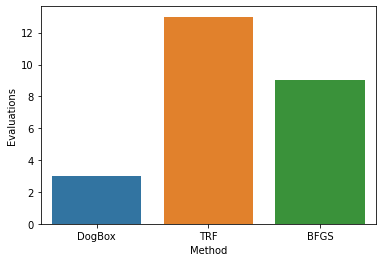

In [58]:
results = pd.DataFrame(
    data=[("DogBox", res_sphere_dogbox['n_criterion_evaluations']),
          ("TRF",res_sphere_trf['n_criterion_evaluations']),
          ("BFGS", res_sphere_bfgs['n_criterion_evaluations'] )],
    columns=["Method", "Evaluations"]
)
_ = sns.barplot(x="Method", y="Evaluations", data=results)

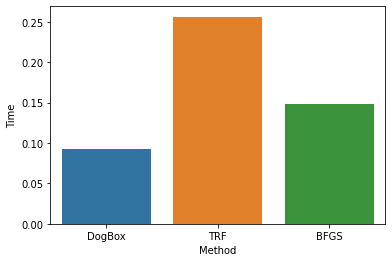

In [59]:
results = pd.DataFrame(
    data=[("DogBox", t_sphere_dogbox),
          ("TRF",t_sphere_trf),
          ("BFGS", t_sphere_bfgs)],
    columns=["Method", "Time"]
)
_ = sns.barplot(x="Method", y="Time", data=results)

The situation looks different for the Rosenbrock function. 

Both methods arrive at an optimal solution. 
However, they require a comparatively high amount of evaluations. 

In [67]:
# With bounds and constraints
res_dogbox = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_dogbox",
    derivative=jac_rosenbrock,
)

res_trf = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_ls_trf",
    derivative=jac_rosenbrock,
)

res_bfgs = minimize(
    criterion=fun_rosenbrock,
    params=x0_rosenbrock,
    algorithm="scipy_bfgs",
    derivative=jac_rosenbrock,
)


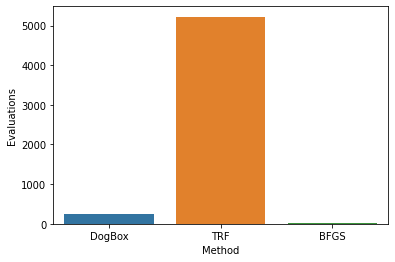

In [68]:
results = pd.DataFrame(
    data=[("DogBox", res_dogbox['n_criterion_evaluations']),
          ("TRF",res_trf['n_criterion_evaluations']),
          ("BFGS",res_bfgs['n_criterion_evaluations'])],
    columns=["Method", "Evaluations"]
)
_ = sns.barplot(x="Method", y="Evaluations", data=results)